## Getting ready

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

import statsmodels
import statsmodels.formula.api as smf
import statsmodels.api as sm

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import auc

In [2]:
df = pd.read_csv('/Users/15827/git_demo/qm_groupwork/data/datasource_updated.csv')
df.columns

Index(['borough_name', 'borough_code', 'borough_area_hectare',
       'green_area_hectare', 'blue _area_hectare', 'green+blue_area_hectare',
       'percent_green', 'percent_blue', 'percent_green+blue', 'healthyweight',
       'overweight', 'happiness', 'anxiety', 'population', 'death_persons',
       'death_males', 'death_females', 'standard_mortality_ratio_persons',
       'standard_mortality_ratio_males', 'standard_mortality_ratio_females',
       'life_expectancy_birth_males', 'life_expectancy_birth_females',
       'life_expectancy_65_males', 'life_expectancy_65_females',
       'DSR_annual_age15+_persons', 'DSR_annual_age15+_males',
       'DSR_annual_age15+_females', 'number_annual_age15+_persons',
       'number_annual_age15+_males', 'number_annual_age15+_females',
       'meanpercent_homes_with_good_access',
       'meanpercent_home_with_deficiency_access',
       'any_neurotic_disorder_per1000', 'all_phobias_per1000',
       'depressive_episode_per1000', 'generalised_anxiety_

In [3]:
df['population'] = df['population'].str.replace(',', '').astype(float)
df['death_persons'] = df['death_persons'].str.replace(',', '').astype(float)
df['green_pp'] = df['green_area_hectare']/df['population']

In [4]:
df1 = df[['percent_green', 'meanpercent_homes_with_good_access', 'green_pp', 
          'death_persons', 'overweight', 'life_expectancy_birth_males', 'life_expectancy_birth_females', 
          'any_neurotic_disorder_per1000', 'all_phobias_per1000', 'depressive_episode_per1000', 'mixed_anxiety_depression']]
df1.columns

Index(['percent_green', 'meanpercent_homes_with_good_access', 'green_pp',
       'death_persons', 'overweight', 'life_expectancy_birth_males',
       'life_expectancy_birth_females', 'any_neurotic_disorder_per1000',
       'all_phobias_per1000', 'depressive_episode_per1000',
       'mixed_anxiety_depression'],
      dtype='object')

Text(0.5, 1.0, 'Correlation Matrix')

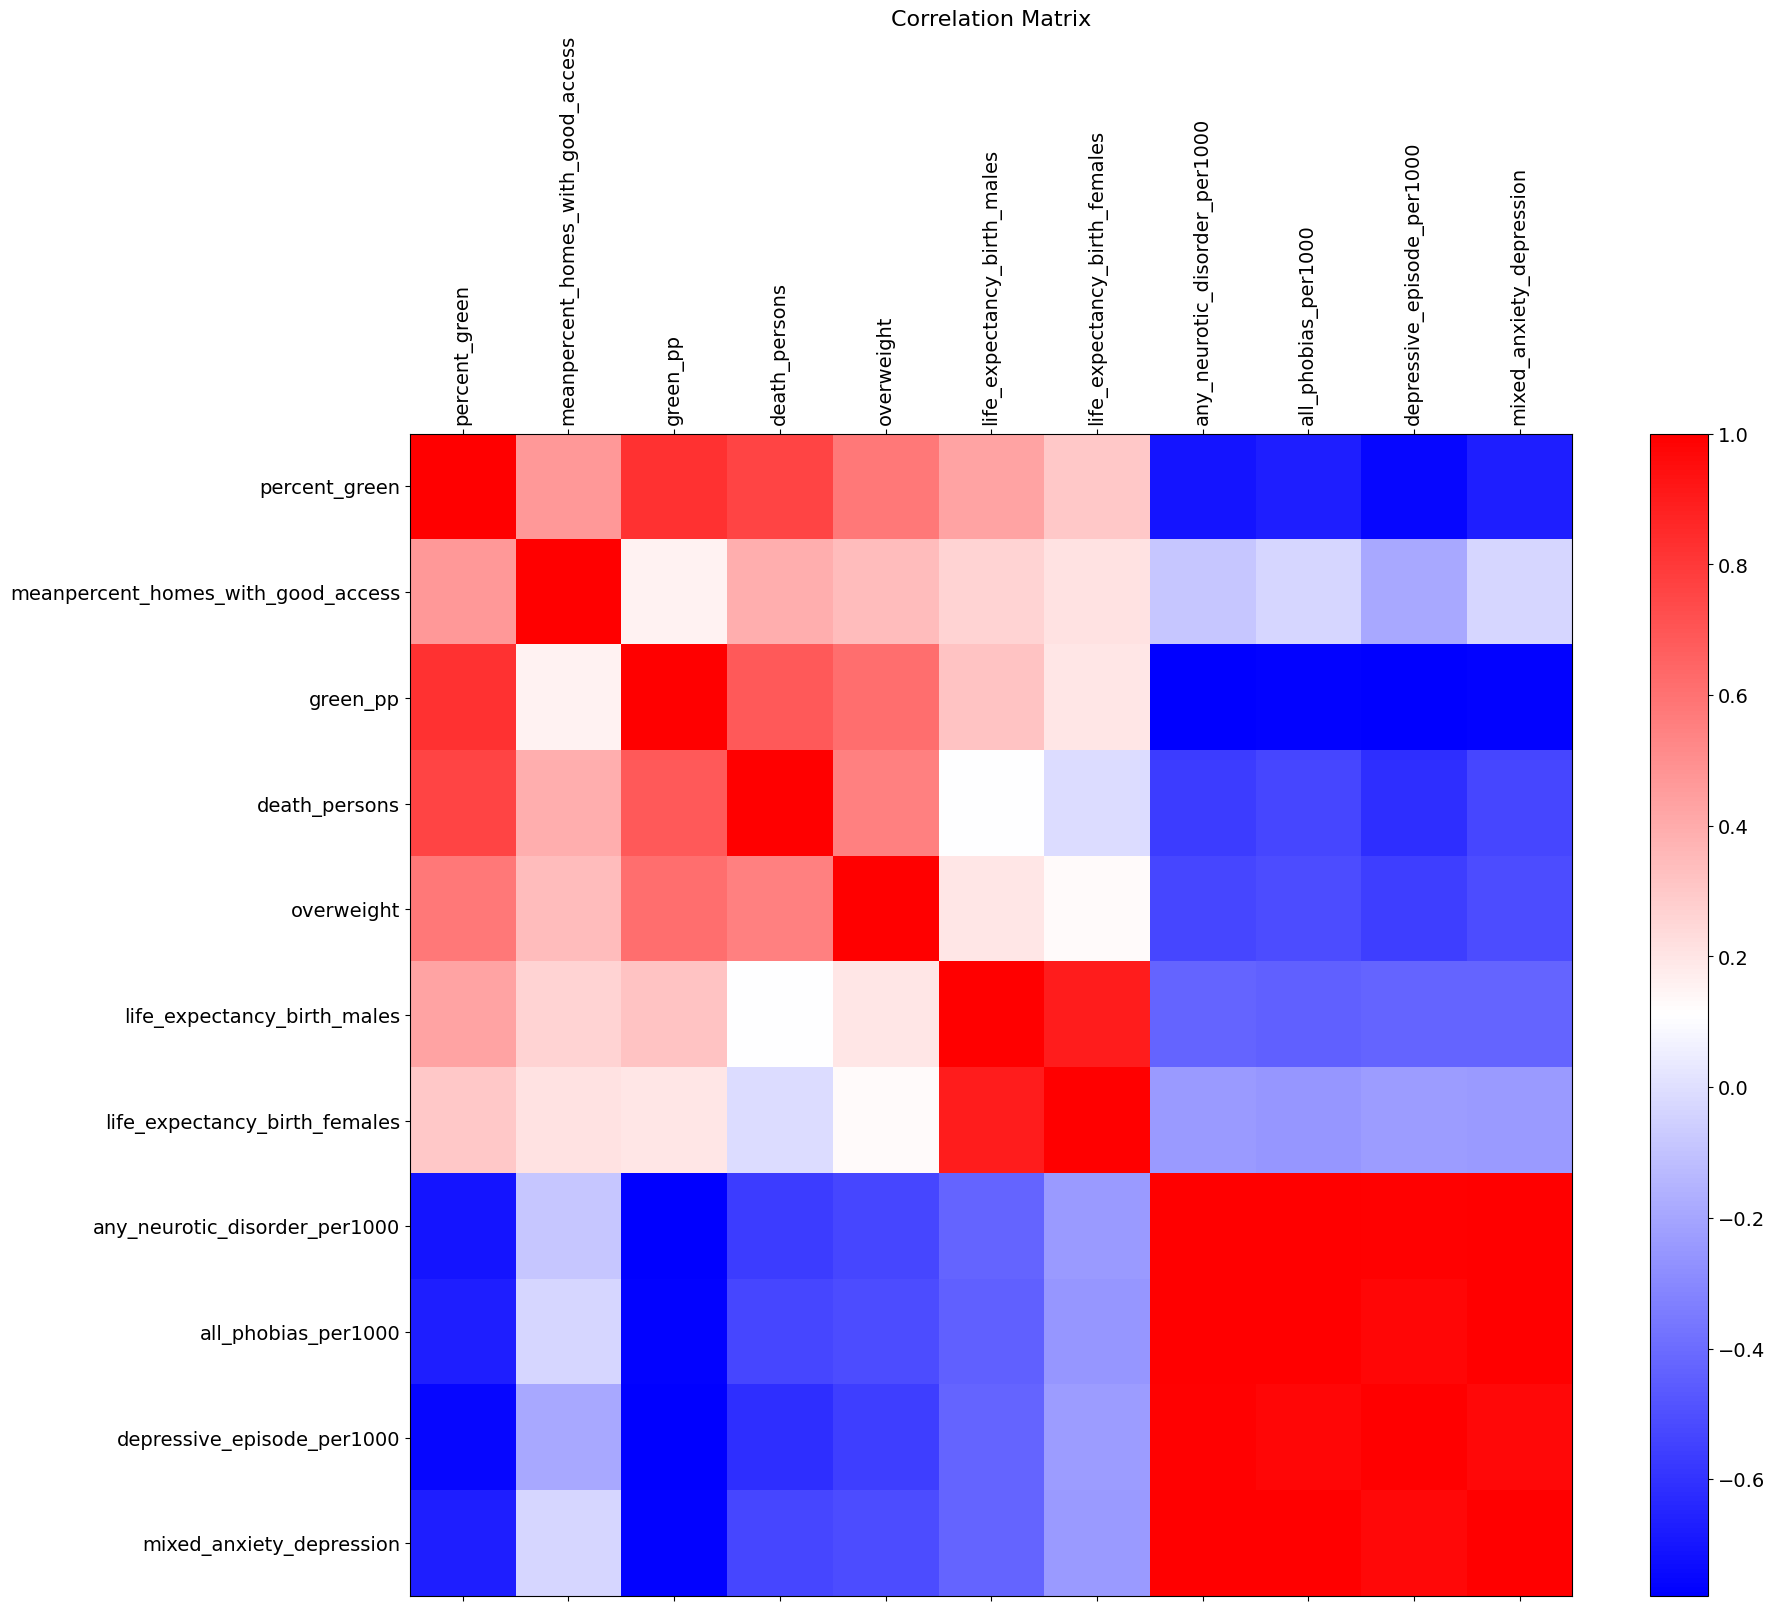

In [5]:
f = plt.figure(figsize = (20, 15))

plt.matshow(df1.corr(), fignum = f.number, cmap = "bwr")
plt.xticks(range(df1.shape[1]), df1.columns, fontsize = 14, rotation = 90)
plt.yticks(range(df1.shape[1]), df1.columns, fontsize = 14)

cb = plt.colorbar()
cb.ax.tick_params(labelsize = 14)
plt.title('Correlation Matrix', fontsize = 16)

## Physical health

#### The original version

In [6]:
model_overweight = sm.OLS(df1['overweight'], sm.add_constant(df1[['percent_green', 'meanpercent_homes_with_good_access', 'green_pp']])).fit()
print(model_overweight.summary())

                            OLS Regression Results                            
Dep. Variable:             overweight   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     7.532
Date:                Wed, 06 Dec 2023   Prob (F-statistic):           0.000714
Time:                        22:16:10   Log-Likelihood:                -75.642
No. Observations:                  33   AIC:                             159.3
Df Residuals:                      29   BIC:                             165.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

#### Overweight

                            OLS Regression Results                            
Dep. Variable:             overweight   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     7.532
Date:                Wed, 06 Dec 2023   Prob (F-statistic):           0.000714
Time:                        22:16:13   Log-Likelihood:                -75.642
No. Observations:                  33   AIC:                             159.3
Df Residuals:                      29   BIC:                             165.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.1541      2.153     14.936      0.0

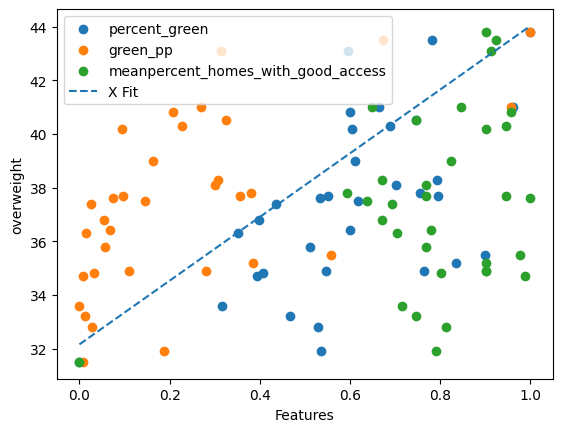

In [7]:
# Fit and transform the entire dataset to obtain scaling parameters
scaler = MinMaxScaler()
df1 = df1.dropna()
df_normalized = scaler.fit_transform(df1[['percent_green', 'green_pp', 'meanpercent_homes_with_good_access']])

y_name = 'overweight'

# Fit the model on the normalized data
model_overweight = sm.OLS(df1[y_name], sm.add_constant(df_normalized)).fit()

# Fit the model on the original data
# model_overweight = sm.OLS(df1['overweight'], sm.add_constant(df[['meanpercent_homes_with_good_access', 'green_pp']])).fit()

# Print model summary
print(model_overweight.summary())

# Transform the features for visualization
x1_normalized = df_normalized[:, 0]
x2_normalized = df_normalized[:, 1]
x3_normalized = df_normalized[:, 2]

# Generate prediction data
x1_pred = np.linspace(x1_normalized.min(), x1_normalized.max(), 100)
x2_pred = np.linspace(x2_normalized.min(), x2_normalized.max(), 100)
x3_pred = np.linspace(x3_normalized.min(), x3_normalized.max(), 100)

# Use add_constant to include the intercept term
X_pred = sm.add_constant(np.column_stack((x1_pred, x2_pred, x3_pred)), has_constant = 'add')

# Predict using the model
y_pred = model_overweight.predict(X_pred)

# Scatter plot
plt.scatter(x1_normalized, df1[y_name], label='percent_green')
plt.scatter(x2_normalized, df1[y_name], label='green_pp')
plt.scatter(x3_normalized, df1[y_name], label='meanpercent_homes_with_good_access')

# Plot the fits
plt.plot(X_pred[:,3], y_pred, label='X Fit', linestyle='--')


plt.xlabel('Features')
plt.ylabel(y_name)
plt.legend()
plt.show()


#### Death persons

                            OLS Regression Results                            
Dep. Variable:          death_persons   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     14.46
Date:                Wed, 06 Dec 2023   Prob (F-statistic):           6.06e-06
Time:                        22:16:18   Log-Likelihood:                -237.97
No. Observations:                  33   AIC:                             483.9
Df Residuals:                      29   BIC:                             489.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        276.6732    294.644      0.939      0.3

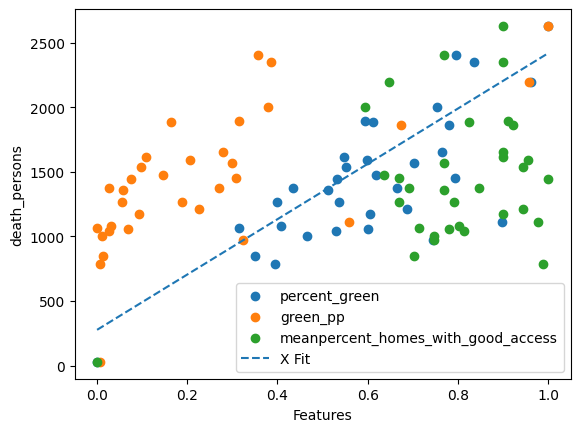

In [8]:
# Fit and transform the entire dataset to obtain scaling parameters
scaler = MinMaxScaler()
df1 = df1.dropna()
df_normalized = scaler.fit_transform(df1[['percent_green', 'green_pp', 'meanpercent_homes_with_good_access']])

y_name = 'death_persons'

# Fit the model on the normalized data
model_overweight = sm.OLS(df1[y_name], sm.add_constant(df_normalized)).fit()

# Fit the model on the original data
# model_overweight = sm.OLS(df1['overweight'], sm.add_constant(df[['meanpercent_homes_with_good_access', 'green_pp']])).fit()

# Print model summary
print(model_overweight.summary())

# Transform the features for visualization
x1_normalized = df_normalized[:, 0]
x2_normalized = df_normalized[:, 1]
x3_normalized = df_normalized[:, 2]

# Generate prediction data
x1_pred = np.linspace(x1_normalized.min(), x1_normalized.max(), 100)
x2_pred = np.linspace(x2_normalized.min(), x2_normalized.max(), 100)
x3_pred = np.linspace(x3_normalized.min(), x3_normalized.max(), 100)

# Use add_constant to include the intercept term
X_pred = sm.add_constant(np.column_stack((x1_pred, x2_pred, x3_pred)), has_constant = 'add')

# Predict using the model
y_pred = model_overweight.predict(X_pred)

# Scatter plot
plt.scatter(x1_normalized, df1[y_name], label='percent_green')
plt.scatter(x2_normalized, df1[y_name], label='green_pp')
plt.scatter(x3_normalized, df1[y_name], label='meanpercent_homes_with_good_access')

# Plot the fits
plt.plot(X_pred[:,3], y_pred, label='X Fit', linestyle='--')


plt.xlabel('Features')
plt.ylabel(y_name)
plt.legend()
plt.show()



#### Life expectancy at birth of males

                                 OLS Regression Results                                
Dep. Variable:     life_expectancy_birth_males   R-squared:                       0.240
Model:                                     OLS   Adj. R-squared:                  0.158
Method:                          Least Squares   F-statistic:                     2.944
Date:                         Wed, 06 Dec 2023   Prob (F-statistic):             0.0501
Time:                                 22:16:54   Log-Likelihood:                -50.574
No. Observations:                           32   AIC:                             109.1
Df Residuals:                               28   BIC:                             115.0
Df Model:                                    3                                         
Covariance Type:                     nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

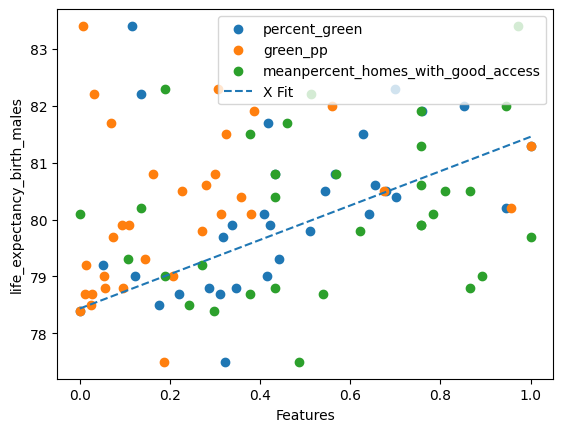

In [10]:
# Fit and transform the entire dataset to obtain scaling parameters
scaler = MinMaxScaler()
df1 = df1.dropna()
df_normalized = scaler.fit_transform(df1[['percent_green', 'green_pp', 'meanpercent_homes_with_good_access']])

y_name = 'life_expectancy_birth_males'

# Fit the model on the normalized data
model_overweight = sm.OLS(df1[y_name], sm.add_constant(df_normalized)).fit()

# Fit the model on the original data
# model_overweight = sm.OLS(df1['overweight'], sm.add_constant(df[['meanpercent_homes_with_good_access', 'green_pp']])).fit()

# Print model summary
print(model_overweight.summary())

# Transform the features for visualization
x1_normalized = df_normalized[:, 0]
x2_normalized = df_normalized[:, 1]
x3_normalized = df_normalized[:, 2]

# Generate prediction data
x1_pred = np.linspace(x1_normalized.min(), x1_normalized.max(), 100)
x2_pred = np.linspace(x2_normalized.min(), x2_normalized.max(), 100)
x3_pred = np.linspace(x3_normalized.min(), x3_normalized.max(), 100)

# Use add_constant to include the intercept term
X_pred = sm.add_constant(np.column_stack((x1_pred, x2_pred, x3_pred)), has_constant = 'add')

# Predict using the model
y_pred = model_overweight.predict(X_pred)

# Scatter plot
plt.scatter(x1_normalized, df1[y_name], label='percent_green')
plt.scatter(x2_normalized, df1[y_name], label='green_pp')
plt.scatter(x3_normalized, df1[y_name], label='meanpercent_homes_with_good_access')

# Plot the fits
plt.plot(X_pred[:,3], y_pred, label='X Fit', linestyle='--')


plt.xlabel('Features')
plt.ylabel(y_name)
plt.legend()
plt.show()


#### Life expectancy at birth of females

                                  OLS Regression Results                                 
Dep. Variable:     life_expectancy_birth_females   R-squared:                       0.144
Model:                                       OLS   Adj. R-squared:                  0.052
Method:                            Least Squares   F-statistic:                     1.564
Date:                           Wed, 06 Dec 2023   Prob (F-statistic):              0.220
Time:                                   22:18:10   Log-Likelihood:                -46.907
No. Observations:                             32   AIC:                             101.8
Df Residuals:                                 28   BIC:                             107.7
Df Model:                                      3                                         
Covariance Type:                       nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

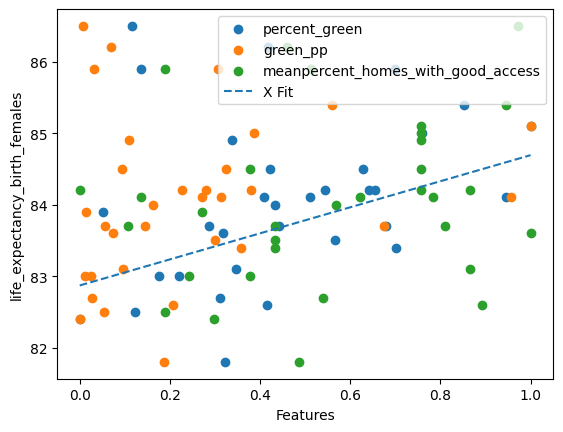

In [11]:
# Fit and transform the entire dataset to obtain scaling parameters
scaler = MinMaxScaler()
df1 = df1.dropna()
df_normalized = scaler.fit_transform(df1[['percent_green', 'green_pp', 'meanpercent_homes_with_good_access']])

y_name = 'life_expectancy_birth_females'

# Fit the model on the normalized data
model_overweight = sm.OLS(df1[y_name], sm.add_constant(df_normalized)).fit()

# Fit the model on the original data
# model_overweight = sm.OLS(df1['overweight'], sm.add_constant(df[['meanpercent_homes_with_good_access', 'green_pp']])).fit()

# Print model summary
print(model_overweight.summary())

# Transform the features for visualization
x1_normalized = df_normalized[:, 0]
x2_normalized = df_normalized[:, 1]
x3_normalized = df_normalized[:, 2]

# Generate prediction data
x1_pred = np.linspace(x1_normalized.min(), x1_normalized.max(), 100)
x2_pred = np.linspace(x2_normalized.min(), x2_normalized.max(), 100)
x3_pred = np.linspace(x3_normalized.min(), x3_normalized.max(), 100)

# Use add_constant to include the intercept term
X_pred = sm.add_constant(np.column_stack((x1_pred, x2_pred, x3_pred)), has_constant = 'add')

# Predict using the model
y_pred = model_overweight.predict(X_pred)

# Scatter plot
plt.scatter(x1_normalized, df1[y_name], label='percent_green')
plt.scatter(x2_normalized, df1[y_name], label='green_pp')
plt.scatter(x3_normalized, df1[y_name], label='meanpercent_homes_with_good_access')

# Plot the fits
plt.plot(X_pred[:,3], y_pred, label='X Fit', linestyle='--')


plt.xlabel('Features')
plt.ylabel(y_name)
plt.legend()
plt.show()


## Mental health

#### Any neurotic disorder per 1000

                                  OLS Regression Results                                 
Dep. Variable:     any_neurotic_disorder_per1000   R-squared:                       0.655
Model:                                       OLS   Adj. R-squared:                  0.618
Method:                            Least Squares   F-statistic:                     17.69
Date:                           Wed, 06 Dec 2023   Prob (F-statistic):           1.23e-06
Time:                                   22:21:39   Log-Likelihood:                -122.96
No. Observations:                             32   AIC:                             253.9
Df Residuals:                                 28   BIC:                             259.8
Df Model:                                      3                                         
Covariance Type:                       nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

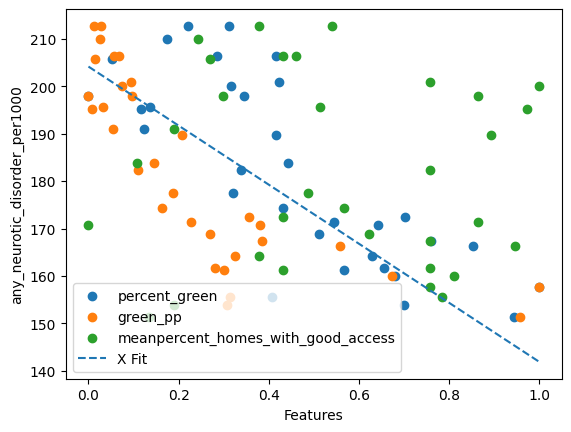

In [12]:
# Fit and transform the entire dataset to obtain scaling parameters
scaler = MinMaxScaler()
df1 = df1.dropna()
df_normalized = scaler.fit_transform(df1[['percent_green', 'green_pp', 'meanpercent_homes_with_good_access']])

y_name = 'any_neurotic_disorder_per1000'

# Fit the model on the normalized data
model_overweight = sm.OLS(df1[y_name], sm.add_constant(df_normalized)).fit()

# Fit the model on the original data
# model_overweight = sm.OLS(df1['overweight'], sm.add_constant(df[['meanpercent_homes_with_good_access', 'green_pp']])).fit()

# Print model summary
print(model_overweight.summary())

# Transform the features for visualization
x1_normalized = df_normalized[:, 0]
x2_normalized = df_normalized[:, 1]
x3_normalized = df_normalized[:, 2]

# Generate prediction data
x1_pred = np.linspace(x1_normalized.min(), x1_normalized.max(), 100)
x2_pred = np.linspace(x2_normalized.min(), x2_normalized.max(), 100)
x3_pred = np.linspace(x3_normalized.min(), x3_normalized.max(), 100)

# Use add_constant to include the intercept term
X_pred = sm.add_constant(np.column_stack((x1_pred, x2_pred, x3_pred)), has_constant = 'add')

# Predict using the model
y_pred = model_overweight.predict(X_pred)

# Scatter plot
plt.scatter(x1_normalized, df1[y_name], label='percent_green')
plt.scatter(x2_normalized, df1[y_name], label='green_pp')
plt.scatter(x3_normalized, df1[y_name], label='meanpercent_homes_with_good_access')

# Plot the fits
plt.plot(X_pred[:,3], y_pred, label='X Fit', linestyle='--')


plt.xlabel('Features')
plt.ylabel(y_name)
plt.legend()
plt.show()


#### All phobias per 1000

                             OLS Regression Results                            
Dep. Variable:     all_phobias_per1000   R-squared:                       0.644
Model:                             OLS   Adj. R-squared:                  0.606
Method:                  Least Squares   F-statistic:                     16.89
Date:                 Wed, 06 Dec 2023   Prob (F-statistic):           1.85e-06
Time:                         22:22:20   Log-Likelihood:                -57.308
No. Observations:                   32   AIC:                             122.6
Df Residuals:                       28   BIC:                             128.5
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.4674      0.818     29.91

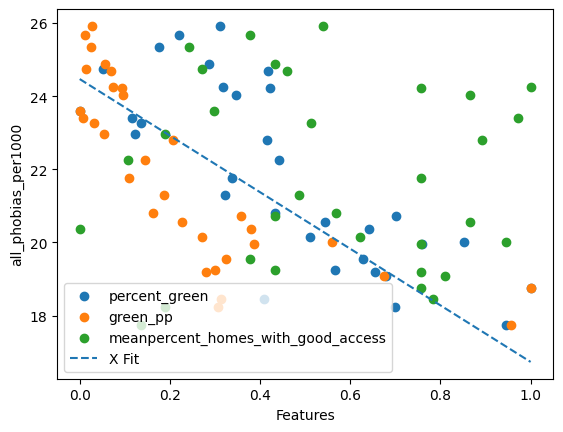

In [13]:
# Fit and transform the entire dataset to obtain scaling parameters
scaler = MinMaxScaler()
df1 = df1.dropna()
df_normalized = scaler.fit_transform(df1[['percent_green', 'green_pp', 'meanpercent_homes_with_good_access']])

y_name = 'all_phobias_per1000'

# Fit the model on the normalized data
model_overweight = sm.OLS(df1[y_name], sm.add_constant(df_normalized)).fit()

# Fit the model on the original data
# model_overweight = sm.OLS(df1['overweight'], sm.add_constant(df[['meanpercent_homes_with_good_access', 'green_pp']])).fit()

# Print model summary
print(model_overweight.summary())

# Transform the features for visualization
x1_normalized = df_normalized[:, 0]
x2_normalized = df_normalized[:, 1]
x3_normalized = df_normalized[:, 2]

# Generate prediction data
x1_pred = np.linspace(x1_normalized.min(), x1_normalized.max(), 100)
x2_pred = np.linspace(x2_normalized.min(), x2_normalized.max(), 100)
x3_pred = np.linspace(x3_normalized.min(), x3_normalized.max(), 100)

# Use add_constant to include the intercept term
X_pred = sm.add_constant(np.column_stack((x1_pred, x2_pred, x3_pred)), has_constant = 'add')

# Predict using the model
y_pred = model_overweight.predict(X_pred)

# Scatter plot
plt.scatter(x1_normalized, df1[y_name], label='percent_green')
plt.scatter(x2_normalized, df1[y_name], label='green_pp')
plt.scatter(x3_normalized, df1[y_name], label='meanpercent_homes_with_good_access')

# Plot the fits
plt.plot(X_pred[:,3], y_pred, label='X Fit', linestyle='--')


plt.xlabel('Features')
plt.ylabel(y_name)
plt.legend()
plt.show()


#### depressive episode per 1000

                                OLS Regression Results                                
Dep. Variable:     depressive_episode_per1000   R-squared:                       0.632
Model:                                    OLS   Adj. R-squared:                  0.592
Method:                         Least Squares   F-statistic:                     16.00
Date:                        Wed, 06 Dec 2023   Prob (F-statistic):           2.98e-06
Time:                                22:27:52   Log-Likelihood:                -68.669
No. Observations:                          32   AIC:                             145.3
Df Residuals:                              28   BIC:                             151.2
Df Model:                                   3                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

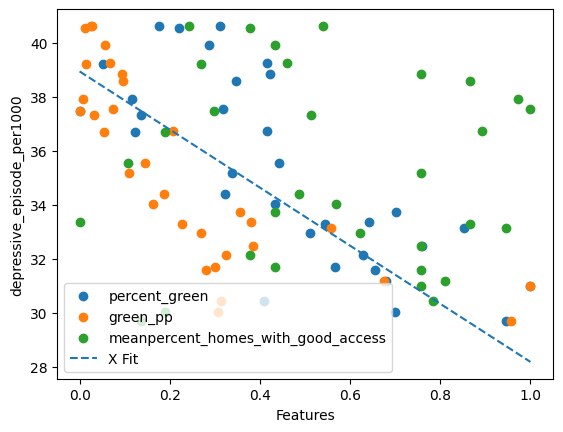

In [14]:
# Fit and transform the entire dataset to obtain scaling parameters
scaler = MinMaxScaler()
df1 = df1.dropna()
df_normalized = scaler.fit_transform(df1[['percent_green', 'green_pp', 'meanpercent_homes_with_good_access']])

y_name = 'depressive_episode_per1000'

# Fit the model on the normalized data
model_overweight = sm.OLS(df1[y_name], sm.add_constant(df_normalized)).fit()

# Fit the model on the original data
# model_overweight = sm.OLS(df1['overweight'], sm.add_constant(df[['meanpercent_homes_with_good_access', 'green_pp']])).fit()

# Print model summary
print(model_overweight.summary())

# Transform the features for visualization
x1_normalized = df_normalized[:, 0]
x2_normalized = df_normalized[:, 1]
x3_normalized = df_normalized[:, 2]

# Generate prediction data
x1_pred = np.linspace(x1_normalized.min(), x1_normalized.max(), 100)
x2_pred = np.linspace(x2_normalized.min(), x2_normalized.max(), 100)
x3_pred = np.linspace(x3_normalized.min(), x3_normalized.max(), 100)

# Use add_constant to include the intercept term
X_pred = sm.add_constant(np.column_stack((x1_pred, x2_pred, x3_pred)), has_constant = 'add')

# Predict using the model
y_pred = model_overweight.predict(X_pred)

# Scatter plot
plt.scatter(x1_normalized, df1[y_name], label='percent_green')
plt.scatter(x2_normalized, df1[y_name], label='green_pp')
plt.scatter(x3_normalized, df1[y_name], label='meanpercent_homes_with_good_access')

# Plot the fits
plt.plot(X_pred[:,3], y_pred, label='X Fit', linestyle='--')


plt.xlabel('Features')
plt.ylabel(y_name)
plt.legend()
plt.show()


#### Mixed anxiety depression

                               OLS Regression Results                               
Dep. Variable:     mixed_anxiety_depression   R-squared:                       0.658
Model:                                  OLS   Adj. R-squared:                  0.621
Method:                       Least Squares   F-statistic:                     17.93
Date:                      Wed, 06 Dec 2023   Prob (F-statistic):           1.09e-06
Time:                              22:28:47   Log-Likelihood:                -100.09
No. Observations:                        32   AIC:                             208.2
Df Residuals:                            28   BIC:                             214.0
Df Model:                                 3                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

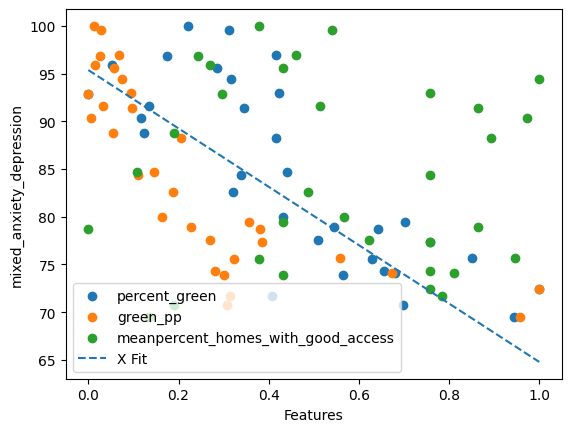

In [15]:
# Fit and transform the entire dataset to obtain scaling parameters
scaler = MinMaxScaler()
df1 = df1.dropna()
df_normalized = scaler.fit_transform(df1[['percent_green', 'green_pp', 'meanpercent_homes_with_good_access']])

y_name = 'mixed_anxiety_depression'

# Fit the model on the normalized data
model_overweight = sm.OLS(df1[y_name], sm.add_constant(df_normalized)).fit()

# Fit the model on the original data
# model_overweight = sm.OLS(df1['overweight'], sm.add_constant(df[['meanpercent_homes_with_good_access', 'green_pp']])).fit()

# Print model summary
print(model_overweight.summary())

# Transform the features for visualization
x1_normalized = df_normalized[:, 0]
x2_normalized = df_normalized[:, 1]
x3_normalized = df_normalized[:, 2]

# Generate prediction data
x1_pred = np.linspace(x1_normalized.min(), x1_normalized.max(), 100)
x2_pred = np.linspace(x2_normalized.min(), x2_normalized.max(), 100)
x3_pred = np.linspace(x3_normalized.min(), x3_normalized.max(), 100)

# Use add_constant to include the intercept term
X_pred = sm.add_constant(np.column_stack((x1_pred, x2_pred, x3_pred)), has_constant = 'add')

# Predict using the model
y_pred = model_overweight.predict(X_pred)

# Scatter plot
plt.scatter(x1_normalized, df1[y_name], label='percent_green')
plt.scatter(x2_normalized, df1[y_name], label='green_pp')
plt.scatter(x3_normalized, df1[y_name], label='meanpercent_homes_with_good_access')

# Plot the fits
plt.plot(X_pred[:,3], y_pred, label='X Fit', linestyle='--')


plt.xlabel('Features')
plt.ylabel(y_name)
plt.legend()
plt.show()
